## Please set below variable `running` to `1` if you run this notebook.
Its purpose is to ensure that interactive functions will display their outputs if you open the notebook on github (without downloading). If you run the notebook without setting `running` to `1` all interactive functions will display twice.

In [129]:
running = 0

`field` is a slice of response table you want to analyse

`feature` is a single column name of responders table

`group` is a slice of people, i.e. men/female/left-handed/right-handed

# Table of content
1. Data preparation 
2. Searching for correlations
    - Principal component analysis for `fields` **(interactive)**
    - Correlations with a chosen `feature` **(interactive)**
    - Searching for interesting correlations
3. Clustering
    - Hierarchical clustering for a chosen `field` **(interactive)**
    - K-means clustering for a chosen `field` **(interactive)**
    - T-SNE **(interactive)**
    - Finding outliners **(interactive)**
4. Other
    - BMI distribution within `genders`
    - `Feature's` distribution between `groups` **(interactive)**
__________________________________________________

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import ipywidgets as widgets
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from pylab import rcParams
from numpy.random import RandomState
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, Dropdown, IntSlider, FloatSlider
from sklearn.manifold import TSNE

Define two functions for cluster analysis visualisation

In [131]:
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates


def pd_centers(featuresUsed, centers):

    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data, size):

    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=size).gca().axes.set_ylim([1,5])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    plt.xticks(rotation=75)
    plt.ylabel('centers of clusters')

## **1. Data preparation**

In [132]:
responses = pd.read_csv("responses.csv")

responses.at[676,'Height'] += 100 # repair a value

Divide dataset onto severall parts

In [133]:
music = responses.loc[:,'Dance':'Opera']
movies = responses.loc[:,'Horror':'Action']
hobbies = responses.loc[:,'History':'Pets']
phobias = responses.loc[:,'Flying':'Fear of public speaking']
personality = responses.loc[:,'Daily events':'Spending on healthy eating'].select_dtypes(include=['int','float'])

Create a path to relate to variables using their names

In [134]:
field_name = {'music':music, 'movies':movies, 'hobbies':hobbies, 'phobias':phobias, 'personality':personality}

### **Define two new features: `braveness` and `BMI`**
Negation of '`breaveness`' is a scaled sum of individual's ratings of all phobias.

*Note: highter value = more brave.*

'`BMI`' stands for 'Body Mass Index'

In [135]:
braveness = (50-phobias.sum(axis=1)) / 10 + 1
bmi = round(responses['Weight'] / (responses['Height'] / 100)**2, 2)


responses_ = responses.copy()
responses_.insert(0, "Braveness", braveness.to_list(), True)
responses_.insert(0, "BMI", bmi.to_list(), True)

# braveness.plot.hist(bins=40, alpha=0.5, density = True)

Filter responses leaving only numerical values

In [136]:
responses_int = responses_.select_dtypes(include=['int','float'])
print(responses_.shape, responses_int.shape)

(1010, 152) (1010, 141)


## **2. Search for correlations**

### 2.1. Principal Component analysis (PCA) for `fields`
For a chosen `field` analyse impact of `number of most relevant components` took into consideration for quality of representing data.

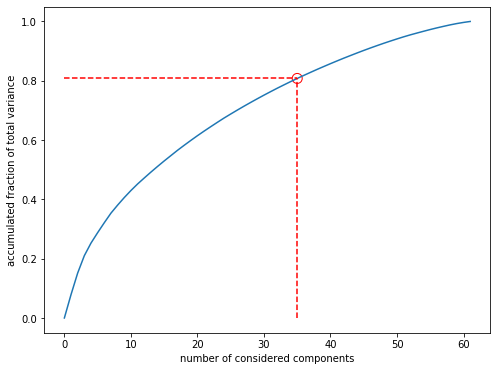

Amount of total variance covered by 35 most impactful components: 0.8079


In [137]:
@interact(field = ['personality','phobias','music','movies','hobbies'], noOfComponents = IntSlider(35,1,60,1))
def PCA(field, noOfComponents): 
    field = field_name[field]
    
    df = field.dropna()
    df_np = np.array(df)

    # Calculate covarriance matrix for all features (columns) in TYPE

    Sigma = np.cov(df_np, rowvar=0, bias=1)

    # Calculate eigenvectors of covarriance matrix

    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)
    
    plt.figure(figsize=(8,6))
    plt.plot([0]+[sum(eigenvalues[-i:]) / sum(eigenvalues) for i in range(1, field.shape[1]+1)])
    plt.xlabel('number of considered components')
    plt.ylabel('accumulated fraction of total variance')
    
    x = noOfComponents
    y = (lambda i: sum(eigenvalues[-i:]) / sum(eigenvalues))(noOfComponents)
    plt.scatter([x], [y], s=100, edgecolors='r', facecolors = 'none')
    plt.plot([x,x], [0,y], c='r', linestyle='dashed')
    plt.plot([0,x], [y,y], c='r', linestyle='dashed')
    plt.show()
    print('Amount of total variance covered by {} most impactful components: {}'.format(x, np.round(y, 4)))

if running == 0:
    PCA('personality', 35)

**Comment 1:**

For `field = personality` 5 most impactful personality features (components) occupy only 29% of total variance, what means that features are **not very correlated (rather independent)**. To cover up 80% of total variance it's necessarily to take 35 most impactful features out of total 61.

### 2.2. Correlations with a chosen `feature`, restricted to a specified `group`

Features correlated with 'Number of friends':


,Feature's name,Coefficient
62,Fun with friends,0.359
63,Adrenaline sports,0.250
74,Fear of public speaking,-0.257
99,Loneliness,-0.317
108,New environment,0.273
111,Socializing,0.329
121,Happiness in life,0.321
122,Energy levels,0.394
124,Personality,0.276
127,Interests or hobbies,0.376


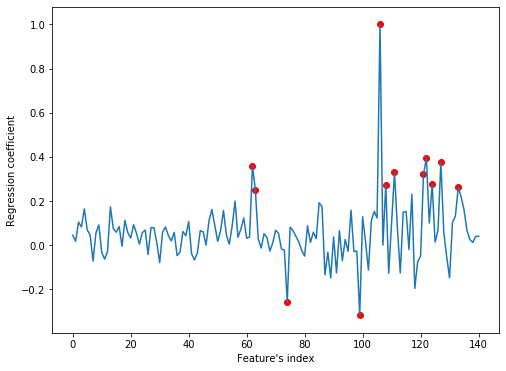

Red dots correspond to features correlated with 'Number of friends'


In [138]:
@interact(feature = IntSlider(106,0,139,1), group = ['all', 'male', 'female', 'right handed', 'left handed'])
def Correlate_with(feature, group):
    
    cols = responses_int.columns.to_list()
    feature = cols[feature]

    # Filter responses according to `group`
    
    if group == 'all':
        responses_int_filtered = responses_int
    if group in {'male', 'female'}:
        responses_int_filtered = responses_int[responses['Gender'] == group]
    if group in {'left handed', 'right handed'}:
        responses_int_filtered = responses_int[responses['Left - right handed'] == group]
    
    # Select 1 columns from correlation's table for specified `group`
    
    correlations = [responses_int_filtered[feature].corr(responses_int_filtered[f]) for f in cols]
    
    # Filter, leaving only interesting correlations
    
    df = pd.DataFrame(correlations, columns = ['Correlations'])
    df = df[abs(df['Correlations']) > 0.25]
    
    # Make pretty visialisation for selected column
    
    corr_features = [cols[f] for f in df.index]
    corr = responses_int_filtered[corr_features].corr().loc[:,feature]

    print("Features correlated with '{}':".format(feature))
    corr_ = {'Feature\'s name':corr.index, 'Coefficient':round(corr,3).to_list()}
    corr_ = pd.DataFrame(corr_, index = df.index)
    corr_ = corr_[corr_['Feature\'s name'] != feature]
    display(corr_)
    
    # Visualise the plot

    plt.figure(figsize=(8,6))
    plt.plot(correlations)
    plt.xlabel('Feature\'s index')
    plt.ylabel('Regression coefficient')
    plt.scatter(df.index, np.array(corr), c='r')
    plt.show()
    print("Red dots correspond to features correlated with '{}'".format(feature))

if running == 0:
    Correlate_with(106, 'all')

### 2.2. Search for interesting correlations
Consider `men` and `women` independently.

Find what features have most correlations with any of 'personality' features.
But focus on features which lead to correlations with similar Pearson's value for **both men and women treated separently**. This approach is crucial, because i.e. if `men` are more likely to be interested in `cars` than `women` and at the same time, `men` are statisticaly `heigher` that `women`, then without considering gender independence we would get a correlation between `cars` and `height`, which is a nonsense.

In [139]:
# Index _1 stands for men, index_2 stands for women

for feature in personality.columns:

    cols = responses_int.columns.to_list()

    # Select 1 column from correlation's table for specified `group`, per group
    
    responses_male = responses_[responses_['Gender'] == 'male']
    responses_female = responses_[responses_['Gender'] == 'female']
    correlations_1 = [responses_male[feature].corr(responses_male[f]) for f in cols ]
    correlations_2 = [responses_female[feature].corr(responses_female[f]) for f in cols ]

    # Filter, leaving only interesting correlations
    
    df_1 = pd.DataFrame(correlations_1, columns = ['Correlations'])
    df_1 = df_1[ abs(df_1['Correlations']) > 0.25]
    df_2 = pd.DataFrame(correlations_2, columns = ['Correlations'])
    df_2 = df_2[ abs(df_2['Correlations']) > 0.25]
    
    # Catch feature's index value
    
    features_index = df_1[df_1['Correlations'] > 0.99].index[0]

    # Preparations for pretty visualisation
    
    corr_features_1 = [cols[f] for f in df_1.index]
    corr_features_2 = [cols[f] for f in df_2.index]

    corr_1 = responses_male[corr_features_1].corr().loc[:,feature].drop([feature])
    corr_2 = responses_female[corr_features_2].corr().loc[:,feature].drop([feature])

    # Find set of features that lead to correlations in both genders
    set_ = set(corr_1.index) & set(corr_2.index)
    
    # If at least 5 distinct correlation are found
    if len(corr_1) > 0 and len(set_) > 5:
        
        corr_ = {'Correlated feature\'s name':list(set_)
                 , 'Coefficient for Men':round(corr_1,3).loc[set_].tolist()
                 , 'Coefficient for Women':round(corr_2,3).loc[set_].tolist()}
        
        corr_ = pd.DataFrame(corr_)
        corr_ = corr_.style.set_caption("Feature\'s name: {}".format(feature)).hide_index()
        print("Feature\'s name ({}): {}:".format(features_index, feature))
        display(corr_)

Feature's name (106): Number of friends:


Correlated feature's name,Coefficient for Men,Coefficient for Women
Interests or hobbies,0.382,0.372
Personality,0.273,0.275
Loneliness,-0.345,-0.287
Socializing,0.35,0.323
Energy levels,0.427,0.367
Fun with friends,0.345,0.369
Happiness in life,0.336,0.299


Feature's name (122): Energy levels:


Correlated feature's name,Coefficient for Men,Coefficient for Women
Interests or hobbies,0.493,0.392
Personality,0.33,0.325
Active sport,0.319,0.322
Loneliness,-0.336,-0.355
Socializing,0.365,0.303
Number of friends,0.427,0.367
New environment,0.325,0.364
Fear of public speaking,-0.281,-0.256
Happiness in life,0.448,0.433


Feature's name (134): Spending on looks:


Correlated feature's name,Coefficient for Men,Coefficient for Women
Spending on gadgets,0.354,0.41
Knowing the right people,0.327,0.287
Branded clothing,0.482,0.422
Appearence and gestures,0.352,0.406
Celebrities,0.267,0.278
Entertainment spending,0.385,0.47
Shopping centres,0.478,0.483
Shopping,0.455,0.544


## 3. Clustering

### 3.1. Hierarchical clustering for a chosen `field`

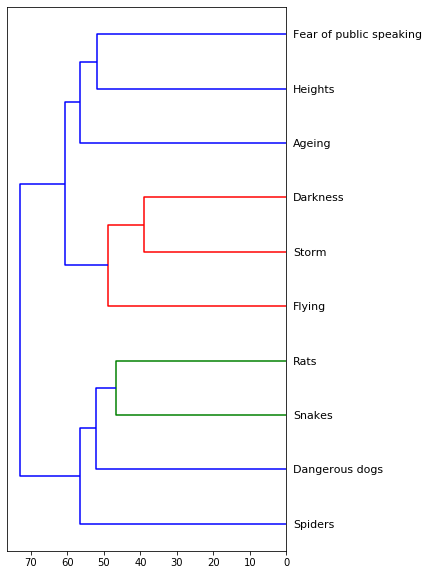

In [140]:
@interact(field = ['phobias','music','movies','hobbies','personality'])
def Hierarchical_cluster(field):
    field = field_name[field]
    
    df_select = field.copy(deep=True).dropna()
    x = df_select.to_numpy().T

    # Adjust figure size to accommodate the full tree

    rcParams['figure.figsize'] = 5, 10

    # Do a hierarchical clustering using Ward's method

    z = sch.linkage(x, method='ward')

    # Display dendrogram

    names = df_select.columns.tolist()
    info = sch.dendrogram(z, orientation='left', labels=names, leaf_font_size=11)
    plt.show()

if running == 0:
    Hierarchical_cluster('phobias')

**Comment 1:** `phobias` seem to have 3 distinct types:
- animals (Rats, Snakes, Dangerous dogs, Spiders)
- nature (Darkness, Storm, Flying)
- social (Fear of public speaking, Heights, Ageing)

**Comment 2:** `music` clusters in 5 distinct types:
- **old music**: rock n roll, jazz, alternative
- **metal-like music**: rock^, punk, metal
- **instrumental music**": opera, classical, country, folk
- **popular music**: latino, musical, pop, dance
- **rap-like music**: reggae, hiphip, techno

^ although rock was assigned to 'yellow label', it's not too far from 'magenta label', which seems more logical

### 3.2. K-means clustering for a chosen `field`

Total sum of squares of distances: 7088.0
__________________________________________________________________________________________

Count of people in each cluster
__________________________________________________________________________________________
0    223
1    384
2    383
dtype: int64


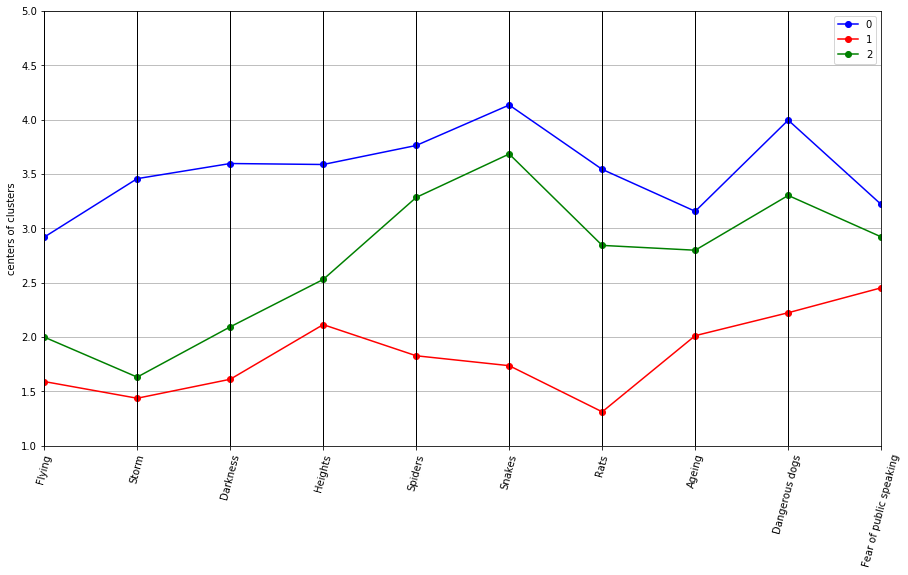

In [141]:
@interact(field = ['phobias','music','movies','hobbies','personality'], noOfClusters = IntSlider(3,1,10,1),
                   randomstate = IntSlider(745,0,10000,10))
def K_means_cluster(field, noOfClusters, randomstate):
    
    field = field_name[field] 
    df_select = field.copy(deep=True).dropna()

    # Perform scaling on the dataframe containing the field's features

    scaler_x = StandardScaler()
    data = scaler_x.fit_transform(df_select)
    
    # Perform K-Means
    
    model = KMeans(init='k-means++', n_clusters=noOfClusters, n_init=20, random_state=randomstate).fit(data)
    
    print("Total sum of squares of distances:", round(model.inertia_))
    print(90*'_')
    print("\nCount of people in each cluster")
    print(90*'_')
    print(pd.value_counts(model.labels_, sort=False))
    
    # Display plot showing centers of clusters
    
    P = pd_centers(featuresUsed=field.columns.to_list(),
                   centers=scaler_x.inverse_transform(model.cluster_centers_))
    parallel_plot(P, (15, 8))
    plt.show()

if running == 0:
    K_means_cluster('phobias', 3, 745)

**Comment 1:**

For `phobias` with `3 clusters` people seem to divide in following types:

- people scared of nothing.
- people scared of various animals.
- people scared of everything.

Using `4 clusters` reveals an additional group, without changing centers of previous `3 clusters`:

- people scared of everything except of animals.

Using `5 clusters` modifies some of previous cluster's centers.

### 3.3. t-SNE
Visualise data of specified `field` by reducing its dimensions to 2D space, using `t-distributed stochastic neighbor embedding`.

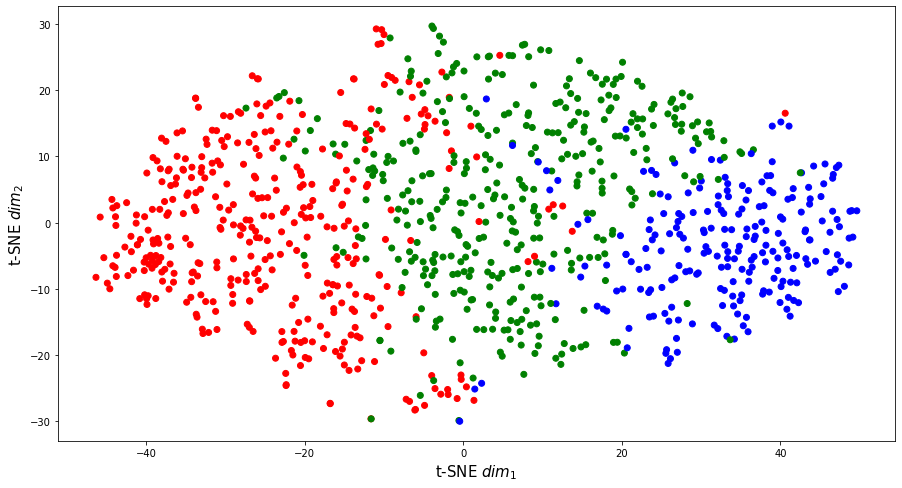

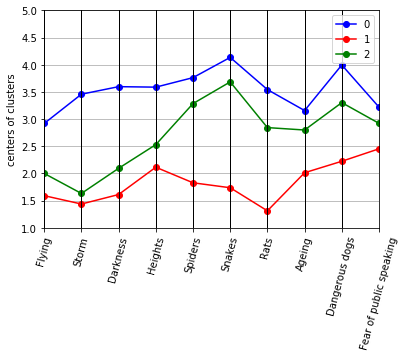

In [142]:
@interact(field = ['phobias','music','movies','hobbies','personality'], noOfClusters = IntSlider(3,1,6,1), 
         randomstate = IntSlider(745,0,10000,10))
def T_SNE_cluster(field, noOfClusters, randomstate):
    
    field = field_name[field] 
    df_select = field.copy(deep=True).dropna()
    
    # Compute K-means to get labels
    
    scaler_x = StandardScaler()
    data = scaler_x.fit_transform(df_select)
    model = KMeans(init='k-means++', n_clusters=noOfClusters,
                   n_init=20, random_state=randomstate).fit(data)

    a = [0, 1, 2, 3, 4, 5, 6]
    b = ['b', 'r', 'g', 'y', 'k', 'm']
    dict_ = dict(zip(a,b))
    colors = [dict_[i] for i in model.labels_]
    
    # Show result of T-SNE

    plt.figure(figsize=(15,8))
    X_embedded = TSNE(n_components=2, random_state=randomstate).fit_transform(data)
    plt.scatter(X_embedded[:,0], X_embedded[:,1], color = colors)
    plt.xlabel('t-SNE $dim_1$', size=15)
    plt.ylabel('t-SNE $dim_2$', size=15)
    plt.show()
    
    # Show result of K-means for labels colors
    
    P = pd_centers(featuresUsed=field.columns.to_list(),
                   centers=scaler_x.inverse_transform(model.cluster_centers_))
    parallel_plot(P, (6, 4))
    plt.show()

if running == 0:
    T_SNE_cluster('phobias', 3, 745)

**Comment 1:**

For `phobias`, using coloring from K-means algorithm, we notice that for `3 clusters` data is well separated, but for `4 clusters` two of the clusters are mixed. This suggests that `3` is trully an appropriate number of clusters.

However, cluster regions are tangential with their bondaries, which means that there exist people who's preferences are on the middle, instead belonging purely to one distinct cluster.

### 3.4. Finding outliners
People who likely cheated by answering randomly.

`allowed_dist` is maximum allowed distance from nearest cluster to not be considered as an outliner

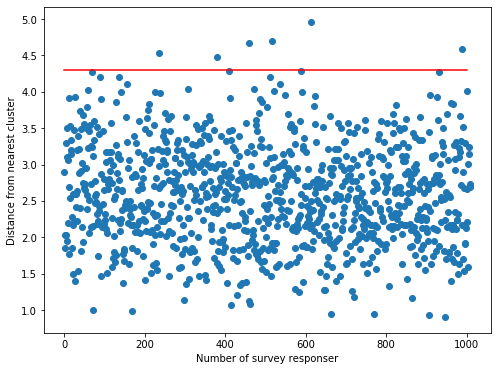

Number of people above the red line: 6
Number of survey responser and its distance from nearest cluster (max 10):

236 	 4.531
378 	 4.472
458 	 4.666
516 	 4.704
614 	 4.957
989 	 4.582

All non-numeric informations about surveyors detected as outliners (max 10):


,Alcohol,Only child,House - block of flats,Gender,Village - town,Punctuality,Education,Internet usage,Lying,Smoking,Left - right handed
236,drink a lot,yes,block of flats,female,city,i am often early,secondary school,less than an hour a day,sometimes,tried smoking,right handed
378,drink a lot,no,block of flats,female,city,i am often running late,secondary school,few hours a day,sometimes,tried smoking,right handed
458,social drinker,no,house/bungalow,female,village,i am often running late,secondary school,few hours a day,only to avoid hurting someone,tried smoking,right handed
516,never,no,block of flats,male,city,i am always on time,secondary school,few hours a day,sometimes,tried smoking,right handed
614,social drinker,no,house/bungalow,female,village,i am often early,secondary school,few hours a day,sometimes,current smoker,right handed
989,drink a lot,no,house/bungalow,female,village,i am often early,masters degree,most of the day,sometimes,former smoker,right handed


In [143]:
@interact(field = ['phobias','music','movies','hobbies','personality'], noOfClusters = IntSlider(3,1,10,1), 
         randomstate = IntSlider(745,0,10000,10), allowed_dist = FloatSlider(value=4.3, min=0, max=12, step=0.1))
def Find_outliners(field, noOfClusters, randomstate, allowed_dist):

    field = field_name[field] 
    df_select = field.copy(deep=True).dropna()
    
    # Compute K-means
    
    scaler_x = StandardScaler()
    data = scaler_x.fit_transform(df_select)
    model = KMeans(init='k-means++', n_clusters=noOfClusters,
                   n_init=20, random_state=randomstate).fit(data)
     
    centers = model.cluster_centers_

    # Plot distance from nearest cluster for all points for which cluster analysis was conducted
    
    plt.figure(figsize=(8,6))
    x = df_select.index.tolist()
    y = [min([np.linalg.norm(a-b) for a in centers]) for b in data[:] ]
    plt.scatter(x,y)
    plt.plot([0,1000], [allowed_dist, allowed_dist], 'red') # Above this line are outliners
    plt.xlabel("Number of survey responser")
    plt.ylabel("Distance from nearest cluster")
    plt.show()

    # Find which points are far away from any cluster. Print their indexies and measured distances
    
    outliners = []
    for i in range(len(y)):
        if y[i] > allowed_dist:
            outliners.append((x[i], y[i], df_select.index[i]))

    print("Number of people above the red line: {}".format(len(outliners)))
    print("Number of survey responser and its distance from nearest cluster (max 10):\n")
    for outliner in outliners[:min(10, len(outliners))]:
        print(outliner[0], "\t", round(outliner[1], 3))

    # Gather all informations about found ouliners, being carefull on index (notice we dropped NaNs)
    
    filter_ = np.full(responses.shape[0], False)
    for outliner in outliners:
        filter_[outliner[2]] = True
    df_ = responses[filter_]

    # Select and display only columns including strings

    df_cols = set(df_.columns) - set(df_.select_dtypes(include=['int','float']).columns)
    print( "\nAll non-numeric informations about surveyors detected as outliners (max 10):")
    display(df_[df_cols][:min(10, df_.shape[0])])

if running == 0:
    Find_outliners('phobias', 3, 745, 4.3)

**Comment 1:**

Seems like most of the outliners are woman. Possibly, woman tend to be more undecisive than men, not necessary being 'cheaters'.

## 4. Other
### 4.1. BMI (body mass index) distribution within `genders`

Text(0, 0.5, 'Density')

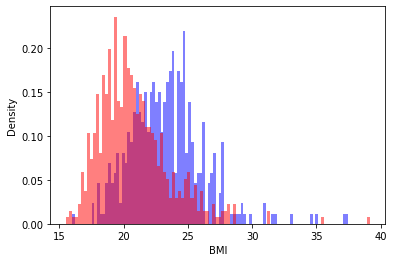

In [144]:
plt.figure(figsize=(6,4))

responses_male = responses_[responses_['Gender'] == 'male']
responses_female = responses_[responses_['Gender'] == 'female']

responses_male['BMI'].plot.hist(bins=100, alpha=0.5, color = 'blue', density = True)
responses_female['BMI'].plot.hist(bins=100, alpha=0.5, color = 'red', density = True)

plt.xlabel('BMI')
plt.ylabel('Density')

**Comment 1:**

both genders have gaussian-like distribution of BMI values, however their mean values differ:
- women's average BMI is around 20
- men's average BMI is around 24

### 4.2. `Feature's` distribution between `groups`.

Fraction distribution for 'God' in group 'all':


1.0    0.185516
2.0    0.121032
3.0    0.214286
4.0    0.163690
5.0    0.315476
Name: God, dtype: float64

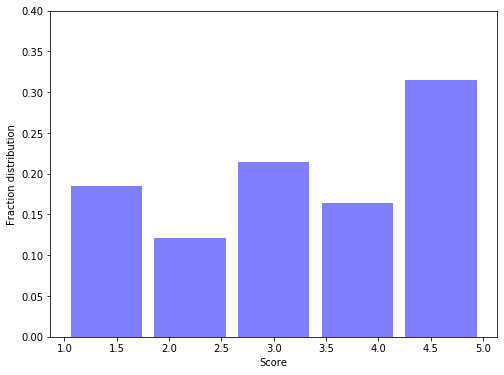

In [145]:
@interact(feature = IntSlider(103,0,139,1), group = ['all', 'male', 'female', 'right handed', 'left handed'])
def Compare(feature, group):
    
    cols = responses_int.columns.to_list()
    feature = cols[feature]

    # Filter responses according to `group`
    
    if group == 'all':
        responses_int_filtered = responses_int
    if group in {'male', 'female'}:
        responses_int_filtered = responses_int[responses['Gender'] == group]
    if group in {'left handed', 'right handed'}:
        responses_int_filtered = responses_int[responses['Left - right handed'] == group]
        
    # Nan values are not plotted, so disclude them in counting 
    
    n = sum(responses_int_filtered[feature] == responses_int_filtered[feature])

    print("Fraction distribution for '{}' in group '{}':".format(feature, group))
    display(responses_int_filtered[feature].value_counts(normalize=True).sort_index())
    
    plt.figure(figsize=(8,6))
    responses_int_filtered[feature].plot.hist(bins=5, alpha=0.5, color='b',
                                              weights = [1./n for i in range(0,n)], rwidth=0.85)
    plt.xlabel('Score')
    plt.ylabel('Fraction distribution')
    plt.ylim(0,0.4)
    plt.show()
    
if running == 0:
    Compare(103, 'all')

**Comment 1:**

Woman are more likely to be religious.
- 36% of woman and 25% of men are strongly religious (5.0 points in survey).
- 15% of woman and 24% of men are atheist-like (1.0 point in survey).